In [1]:
library(dplyr)
library(foreach)
library(doParallel)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: iterators

Loading required package: parallel



In [3]:
# Function to generate all possible motifs from an ambiguous RNA motif
generate_all_motifs <- function(ambiguous_motif) {
  nucleotide_map <- list(
    'a' = 'a', 'c' = 'c', 'g' = 'g', 'u' = 'u',
    'r' = c('a', 'g'), 'y' = c('c', 'u'), 's' = c('g', 'c'),
    'w' = c('a', 'u'), 'k' = c('g', 'u'), 'm' = c('a', 'c'),
    'b' = c('c', 'g', 'u'), 'd' = c('a', 'g', 'u'), 'h' = c('a', 'c', 'u'),
    'v' = c('a', 'c', 'g'), 'n' = c('a', 'c', 'g', 'u')
  )
  
  motif_chars <- strsplit(ambiguous_motif, "")[[1]]
  
  motif_options <- lapply(motif_chars, function(char) nucleotide_map[[char]])
  
  all_combinations <- expand.grid(motif_options, stringsAsFactors = FALSE)
  all_motifs <- apply(all_combinations, 1, paste, collapse = "")
  print(all_motifs)
  
  return(all_motifs)
}

# Function to compute the KMP prefix array (pi array) to find the length of the longest proper self-overlap (k)
compute_kmp_pi <- function(motif) {
  n <- nchar(motif)
  if (n == 0) {
    return(c())
  }
  pi <- integer(n)
  k <- 0
  for (q in 2:n) {
    while (k > 0 && substr(motif, k + 1, k + 1) != substr(motif, q, q)) {
      k <- pi[k]
    }
    if (substr(motif, k + 1, k + 1) == substr(motif, q, q)) {
      k <- k + 1
    }
    pi[q] <- k
  }
  print(pi)
  return(pi)
}

# Function to find the best motif that maximizes occurrences in a sequence of length L
find_best_motif <- function(ambiguous_motif, L) {
  ambiguous_motif <- gsub(" ", "", ambiguous_motif)
  all_possible_motifs <- generate_all_motifs(ambiguous_motif)
  
  best_motif <- NULL
  max_occurrences <- -1
  
  for (motif in all_possible_motifs) {
    motif_len <- nchar(motif)
    
    # Calculate occurrences only if the motif can fit in the sequence
    if (L >= motif_len) {
      pi_array <- compute_kmp_pi(motif)
      k <- pi_array[motif_len]
      
      current_occurrences <- floor((L - motif_len) / (motif_len - k)) + 1
      
      if (current_occurrences > max_occurrences) {
        max_occurrences <- current_occurrences
        best_motif <- motif
      }
    } else {
      current_occurrences <- 0
      if (current_occurrences > max_occurrences) {
        max_occurrences <- current_occurrences
        best_motif <- motif
      }
    }
  }
  
  return(list(best_motif = best_motif, max_occurrences = max_occurrences))
}

# Function to compute summary statistics for RBP results
rbp_summary_stats <- function(rbp_res, num_valid_seq){
  # Compute max possible slots a motif can co-occur on seq of a given length
  cl <- makeCluster(detectCores() - 1)
  registerDoParallel(cl)
  num_possible_slots <- foreach(i = 1:nrow(rbp_res), .combine = 'c', .export = c("generate_all_motifs","compute_kmp_pi","find_best_motif")) %dopar% {
    res <- find_best_motif(rbp_res[i,'Motif'],rbp_res[i,'seqlen'])
    return(res$max_occurrences)
  }
  stopCluster(cl)
  rbp_res$num_possible_slots <- num_possible_slots
  # Average normalized number of occurrences of some motif on a sequence
  num_occur_norm <- rbp_res %>%
    group_by(SeqName, Protein) %>%
    summarise(
      occurrence_count = n(),
      max_num_possible_slots = max(num_possible_slots, na.rm = TRUE)
    ) %>%
    mutate(
      num_occur_norm = occurrence_count / max_num_possible_slots
    )
  num_occur_norm_byrbp <- num_occur_norm %>% group_by(Protein)
  avg_num_occur_norm <- num_occur_norm_byrbp %>%
    summarise(avg_num_occur_norm = mean(num_occur_norm))
  summary_stats <- num_occur_norm_byrbp %>%
    summarise(avg_num_occur_norm_weighted = sum(num_occur_norm)/num_valid_seq)
  
  return(list(rbp_res=rbp_res,
              num_occur_norm=num_occur_norm,
              num_occur_norm_byrbp=num_occur_norm_byrbp,
              avg_num_occur_norm=avg_num_occur_norm,
              summary_stats=summary_stats))
  
}

### Reformating RBP outputs

In [ ]:
!bash rbp_format_transform.sh
# Obtain sequence length
!bash  seq_len.sh

### Lengthening

In [ ]:
setwd('~/Desktop/Research/scPASU_pipeline_runs/Ureter10_scPASU_run/outputs/differentiation_stage_cellranger_peakcount/')

# Processing RBP results for lengthening differential 3'UTR sequences
lgthn_rbp <- read.csv('rbp_binding_motifs/U10APAlengthening3UTR_Strict/U10APAlengthening3UTR_Strict_All_Predictions.txt')
lgthn_rbp$Motif <- gsub(" ", "",lgthn_rbp$Motif)
lgthn_len <- read.delim('WUI_APA_genes_UTR3_lengthening_ranges_seqlen.txt')
lgthn_rbp <- left_join(lgthn_rbp,lgthn_len,by='SeqName')
# Calculate summary statistics, i.e. normalized occurrences per RBP
lgthn_rbp_stats <- rbp_summary_stats(lgthn_rbp,num_valid_seq = 131)
lgthn_rbp_stats[["num_occur_norm_byrbp"]] %>%
  filter(Protein == 'A1CF(Hs/Mm)')

# Processing RBP results for corresponding NULL
lgthnNULL_rbp <- read.csv('rbp_binding_motifs/U10APAlengthening3UTRNULL_Strict/U10APAlengthening3UTRNULL_Strict_All_Predictions.txt')
lgthnNULL_rbp$Motif <- gsub(" ", "",lgthnNULL_rbp$Motif)
lgthnNULL_len <- read.delim('WUI_APA_genes_UTR3_lengthening_ranges_NULL_seqlen.txt')
lgthnNULL_rbp <- left_join(lgthnNULL_rbp,lgthnNULL_len,by='SeqName')
# Calculate summary statistics, i.e. normalized occurrences per RBP
lgthnNULL_rbp_stats <-rbp_summary_stats(lgthnNULL_rbp,num_valid_seq = 1310)
lgthnNULL_rbp_stats[["num_occur_norm_byrbp"]]

# Extract summary statistics
lgthn_rbp_stats_summary <- lgthn_rbp_stats$summary_stats
lgthnNULL_rbp_stats_summary <- lgthnNULL_rbp_stats$summary_stats

# saveRDS(lgthn_rbp_stats,'rbp_binding_motifs/U10APAlengthening3UTR_Strict/U10APAlengthening3UTR_Strict_SummaryStats_new.rds')
# saveRDS(lgthnNULL_rbp_stats,'rbp_binding_motifs/U10APAlengthening3UTRNULL_Strict/U10APAlengthening3UTRNULL_Strict_SummaryStats_new.rds')

`summarise()` has grouped output by 'SeqName'. You can override using the
`.groups` argument.


SeqName,Protein,occurrence_count,max_num_possible_slots,num_occur_norm
<chr>,<chr>,<int>,<dbl>,<dbl>
ADD1_UTR3(+),A1CF(Hs/Mm),7,493,0.014198783
AGPAT3_UTR3(+),A1CF(Hs/Mm),23,540,0.042592593
AK2_UTR3(-),A1CF(Hs/Mm),55,858,0.064102564
AKAP9_UTR3(+),A1CF(Hs/Mm),94,643,0.146189736
ANKIB1_UTR3(+),A1CF(Hs/Mm),151,652,0.231595092
APH1B_UTR3(+),A1CF(Hs/Mm),56,844,0.066350711
ARHGAP12_UTR3(-),A1CF(Hs/Mm),70,309,0.226537217
ARHGAP32_UTR3(-),A1CF(Hs/Mm),109,781,0.139564661
ARRDC1_UTR3(+),A1CF(Hs/Mm),3,366,0.008196721


`summarise()` has grouped output by 'SeqName'. You can override using the
`.groups` argument.


SeqName,Protein,occurrence_count,max_num_possible_slots,num_occur_norm
<chr>,<chr>,<int>,<dbl>,<dbl>
Seq1(+),ANKHD1(Hs/Mm),1,329,0.0030395137
Seq1(+),BOLL(Hs/Mm),2,329,0.0060790274
Seq1(+),BRUNOL4(Hs/Mm),3,985,0.0030456853
Seq1(+),BRUNOL5(Hs/Mm),4,985,0.0040609137
Seq1(+),BRUNOL6(Hs/Mm),1,394,0.0025380711
Seq1(+),CELF1(Hs/Mm),2,329,0.0060790274
Seq1(+),CNOT4(Hs/Mm),8,493,0.0162271805
Seq1(+),CPEB4(Hs/Mm),1,1970,0.0005076142
Seq1(+),DAZ3(Hs/Mm),1,493,0.0020283976


In [ ]:
# ks.test of average normalized occurrences across all RBPs between lengthening and NULL
ks.test(lgthn_rbp_stats_summary$avg_num_occur_norm_weighted, lgthnNULL_rbp_stats_summary$avg_num_occur_norm_weighted)

Warning message in ks.test.default(lgthn_rbp_stats_summary$avg_num_occur_norm_weighted, :
“p-value will be approximate in the presence of ties”



	Asymptotic two-sample Kolmogorov-Smirnov test

data:  lgthn_rbp_stats_summary$avg_num_occur_norm_weighted and lgthnNULL_rbp_stats_summary$avg_num_occur_norm_weighted
D = 0.083333, p-value = 0.7491
alternative hypothesis: two-sided


#### KS test by RBP

In [9]:
lgthn_rbp_stats <- readRDS('rbp_binding_motifs/U10APAlengthening3UTR_Strict/U10APAlengthening3UTR_Strict_SummaryStats_new.rds')
lgthnNULL_rbp_stats <- readRDS('rbp_binding_motifs/U10APAlengthening3UTRNULL_Strict/U10APAlengthening3UTRNULL_Strict_SummaryStats_new.rds')

ks_lgthn <- matrix(ncol = 7, nrow = 0) %>% as.data.frame()
colnames(ks_lgthn) <- c("Protein","statistic.D","p.value","alternative","method","data.name","exact")
 
# Valid means sequences compatible as RBP input
num_valid_seq = 131
num_valid_NULLseq = 1310

for (rbp in unique(lgthn_rbp_stats[["num_occur_norm_byrbp"]]$Protein)){
  rbp_data <- lgthn_rbp_stats[["num_occur_norm_byrbp"]] %>%
    filter(Protein == rbp)
  # Add zeros for sequences with no occurrences
  num_zeros = num_valid_seq - length(rbp_data$num_occur_norm)
  rbp_data <- c(rbp_data$num_occur_norm,rep(0,num_zeros))

  rbp_null_data <- lgthnNULL_rbp_stats[["num_occur_norm_byrbp"]] %>%
    filter(Protein == rbp)
  # Add zeros for sequences with no occurrences
  num_null_zeros = num_valid_NULLseq - length(rbp_null_data$num_occur_norm)
  rbp_null_data <- c(rbp_null_data$num_occur_norm,rep(0,num_null_zeros))
  
  # simulate p-value because data are zero-inflated
  ks.res <- ks.test(rbp_data,rbp_null_data, simulate.p.value = TRUE)
  df <- t(c('Protein'=rbp,unlist(ks.res))) %>% as.data.frame()
  ks_lgthn <- rbind(ks_lgthn,df)
}

# Adjust p-values for multiple testing
ks_lgthn$p.adj.value <- p.adjust(ks_lgthn$p.value, method = "fdr")
# Supplemntary Table S5
# write.table(ks_lgthn,'rbp_binding_motifs/U10APAlengthening_KS_res.txt',sep='\t',row.names=FALSE,col.names=TRUE,quote=FALSE)

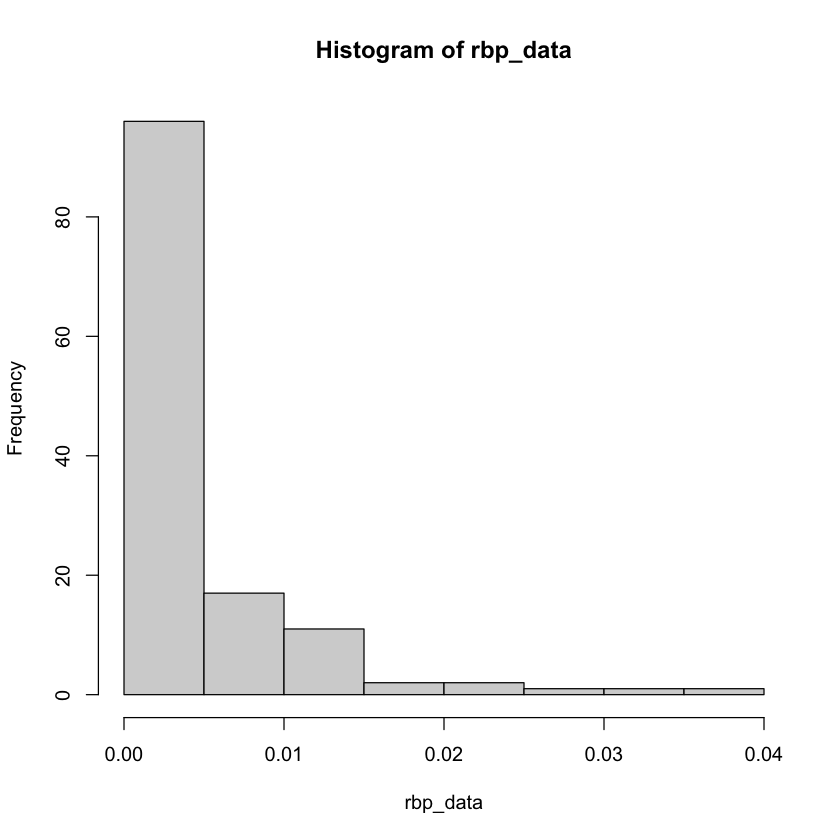

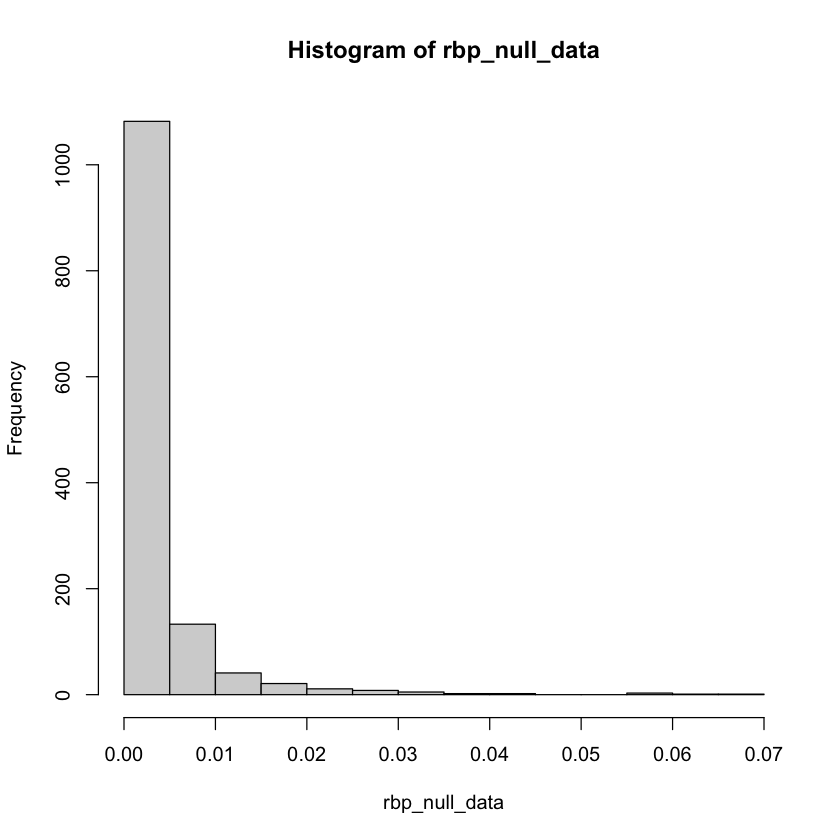

In [10]:
# Visualize distributions for a specific RBP
rbp = 'ESRP1(Hs/Mm)'
rbp_data <- lgthn_rbp_stats[["num_occur_norm_byrbp"]] %>%
  filter(Protein == rbp)
num_zeros = num_valid_seq - length(rbp_data$num_occur_norm)
rbp_data <- c(rbp_data$num_occur_norm,rep(0,num_zeros))

rbp_null_data <- lgthnNULL_rbp_stats[["num_occur_norm_byrbp"]] %>%
  filter(Protein == rbp)
num_null_zeros = num_valid_NULLseq - length(rbp_null_data$num_occur_norm)
rbp_null_data <- c(rbp_null_data$num_occur_norm,rep(0,num_null_zeros))

hist(rbp_data)
hist(rbp_null_data)

### Shortening

In [11]:
# Processing RBP results for shortening differential 3'UTR sequences
shntn_rbp <- read.csv('rbp_binding_motifs/U10APAshortening3UTR_Strict/U10APAshortening3UTR_Strict_All_Predictions.txt')
shntn_rbp$Motif <- gsub(" ", "",shntn_rbp$Motif)
shntn_len <- read.delim('WUI_APA_genes_UTR3_shortening_ranges_seqlen.txt')
shntn_rbp <- left_join(shntn_rbp,shntn_len,by='SeqName')
# Calculate summary statistics, i.e. normalized occurrences per RBP
shntn_rbp_stats <- rbp_summary_stats(shntn_rbp,num_valid_seq = 164)

# Processing RBP results for corresponding NULL
shntnNULL_rbp <- read.csv('rbp_binding_motifs/U10APAshortening3UTRNULL_Strict/U10APAshortening3UTRNULL_Strict_All_Predictions.txt')
shntnNULL_rbp$Motif <- gsub(" ", "",shntnNULL_rbp$Motif)
shntnNULL_len <- read.delim('WUI_APA_genes_UTR3_shorterning_ranges_NULL_seqlen.txt')
shntnNULL_rbp <- left_join(shntnNULL_rbp,shntnNULL_len,by='SeqName')
# Calculate summary statistics, i.e. normalized occurrences per RBP
shntnNULL_rbp_stats <-rbp_summary_stats(shntnNULL_rbp,num_valid_seq = 1640)

shntn_rbp_stats_summary <- shntn_rbp_stats$summary_stats
shntnNULL_rbp_stats_summary <- shntnNULL_rbp_stats$summary_stats

# saveRDS(shntn_rbp_stats,'rbp_binding_motifs/U10APAshortening3UTR_Strict/U10APAshortening3UTR_Strict_SummaryStats_new.rds')
# saveRDS(shntnNULL_rbp_stats,'rbp_binding_motifs/U10APAshortening3UTRNULL_Strict/U10APAshortening3UTRNULL_Strict_SummaryStats_new.rds')

`summarise()` has grouped output by 'SeqName'. You can override using the
`.groups` argument.
`summarise()` has grouped output by 'SeqName'. You can override using the
`.groups` argument.


In [ ]:
# ks.test of average normalized occurrences across all RBPs between shortening and NULL
ks.test(shntn_rbp_stats_summary$avg_num_occur_norm_weighted, shntnNULL_rbp_stats_summary$avg_num_occur_norm_weighted)

Warning message in ks.test.default(shntn_rbp_stats_summary$avg_num_occur_norm_weighted, :
“p-value will be approximate in the presence of ties”



	Asymptotic two-sample Kolmogorov-Smirnov test

data:  shntn_rbp_stats_summary$avg_num_occur_norm_weighted and shntnNULL_rbp_stats_summary$avg_num_occur_norm_weighted
D = 0.068182, p-value = 0.9188
alternative hypothesis: two-sided


#### KS test by RBP

In [13]:
shntn_rbp_stats <- readRDS('rbp_binding_motifs/U10APAshortening3UTR_Strict/U10APAshortening3UTR_Strict_SummaryStats_new.rds')
shntnNULL_rbp_stats <- readRDS('rbp_binding_motifs/U10APAshortening3UTRNULL_Strict/U10APAshortening3UTRNULL_Strict_SummaryStats_new.rds')

ks_shntn <- matrix(ncol = 7, nrow = 0) %>% as.data.frame()
colnames(ks_shntn) <- c("Protein","statistic.D","p.value","alternative","method","data.name","exact")

num_valid_seq = 164
num_valid_NULLseq = 1640

for (rbp in unique(shntn_rbp_stats[["num_occur_norm_byrbp"]]$Protein)){
  rbp_data <- shntn_rbp_stats[["num_occur_norm_byrbp"]] %>%
    filter(Protein == rbp)
  # Add zeros for sequences with no occurrences
  num_zeros = num_valid_seq - length(rbp_data$num_occur_norm)
  rbp_data <- c(rbp_data$num_occur_norm,rep(0,num_zeros))
  
  rbp_null_data <- shntnNULL_rbp_stats[["num_occur_norm_byrbp"]] %>%
    filter(Protein == rbp)
  # Add zeros for sequences with no occurrences
  num_null_zeros = num_valid_NULLseq - length(rbp_null_data$num_occur_norm)
  rbp_null_data <- c(rbp_null_data$num_occur_norm,rep(0,num_null_zeros))
  print(paste(num_zeros/num_valid_seq,num_null_zeros/num_valid_NULLseq))
  # simulate p-value because data are zero-inflated
  ks.res <- ks.test(rbp_data,rbp_null_data, simulate.p.value = TRUE)
  df <- t(c('Protein'=rbp,unlist(ks.res))) %>% as.data.frame()
  ks_shntn <- rbind(ks_shntn,df)
}

ks_shntn$p.adj.value <- p.adjust(ks_shntn$p.value, method = "fdr")
# Supplemntary Table S5
# write.table(ks_shntn,'rbp_binding_motifs/U10APAshortening_KS_res.txt',sep='\t',row.names=FALSE,col.names=TRUE,quote=FALSE)
ks_shntn <- read.delim('rbp_binding_motifs/U10APAshortening_KS_res.txt')

[1] "0.0548780487804878 0.0859756097560976"
[1] "0.573170731707317 0.560365853658537"
[1] "0.048780487804878 0.0481707317073171"
[1] "0.0853658536585366 0.123780487804878"
[1] "0.0792682926829268 0.117073170731707"
[1] "0.225609756097561 0.267682926829268"
[1] "0.0426829268292683 0.0707317073170732"
[1] "0.0731707317073171 0.11280487804878"
[1] "0.0426829268292683 0.0689024390243902"
[1] "0.048780487804878 0.0823170731707317"
[1] "0.024390243902439 0.0695121951219512"
[1] "0.0365853658536585 0.0463414634146341"
[1] "0.0609756097560976 0.0890243902439024"
[1] "0.176829268292683 0.254268292682927"
[1] "0.0121951219512195 0.048780487804878"
[1] "0.341463414634146 0.389634146341463"
[1] "0.378048780487805 0.56219512195122"
[1] "0.317073170731707 0.383536585365854"
[1] "0.298780487804878 0.379268292682927"
[1] "0.50609756097561 0.527439024390244"
[1] "0.024390243902439 0.0567073170731707"
[1] "0.0304878048780488 0.049390243902439"
[1] "0.670731707317073 0.739634146341463"
[1] "0.26219512195

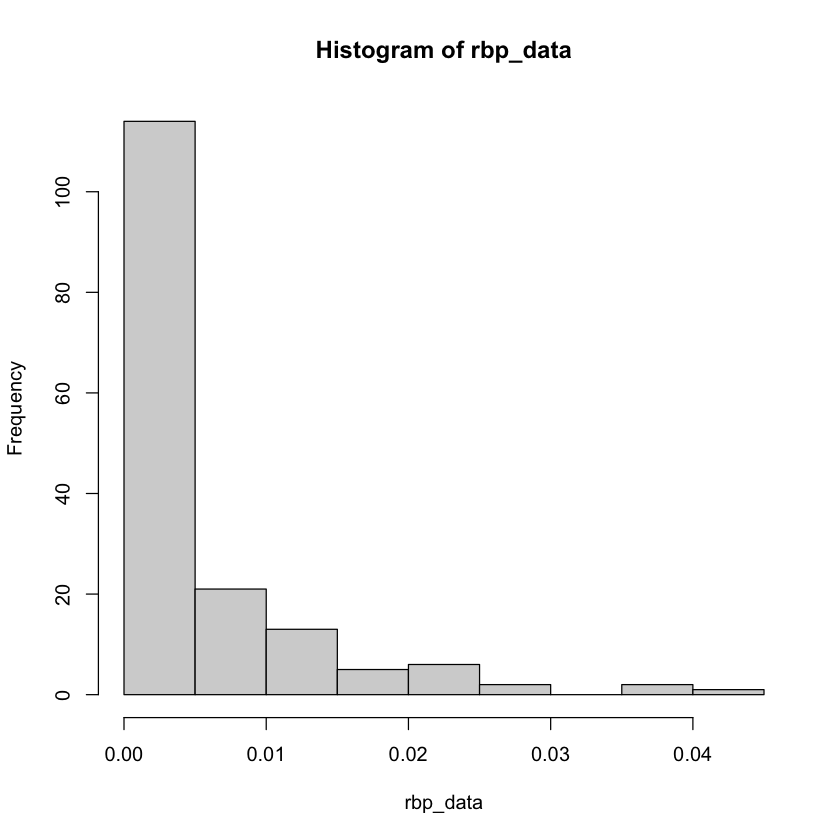

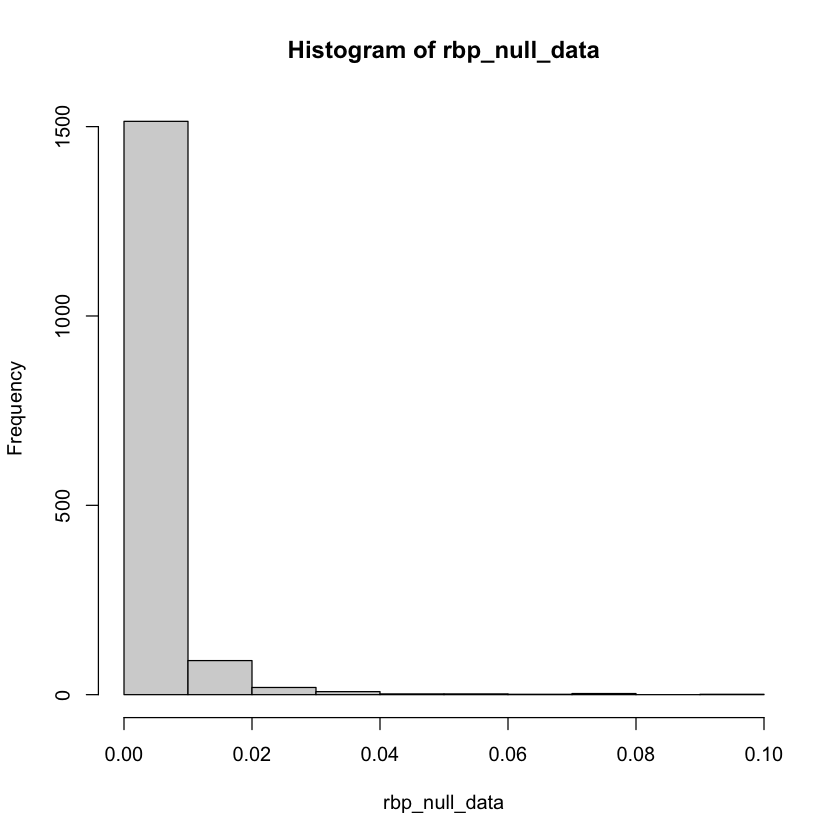

In [14]:
rbp = 'ESRP1(Hs/Mm)'
rbp_data <- shntn_rbp_stats[["num_occur_norm_byrbp"]] %>%
  filter(Protein == rbp)
num_zeros = num_valid_seq - length(rbp_data$num_occur_norm)
rbp_data <- c(rbp_data$num_occur_norm,rep(0,num_zeros))

rbp_null_data <- shntnNULL_rbp_stats[["num_occur_norm_byrbp"]] %>%
  filter(Protein == rbp)
num_null_zeros = num_valid_NULLseq - length(rbp_null_data$num_occur_norm)
rbp_null_data <- c(rbp_null_data$num_occur_norm,rep(0,num_null_zeros))

hist(rbp_data)
hist(rbp_null_data)